In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sphviewer.tools import QuickView
import illustris_python as il
import physics
import tng100_test

In [2]:
tng_run = "tng-100-1"
snapshot = 99
test_name = "kappa_rot_2602"
subhalo_id = 438787
subhalos = [348038, 438787, 601952, 271729, 443683, 618886, 225155, 565654, 704187]

In [3]:
def stars_out(tng_run, snapshot, i):
    #intitial setup
    base_path = "../data/" + str(tng_run) + "/output"
    fields = {"stars": ["Coordinates", "Potential", "Masses", "Velocities", "GFM_StellarPhotometrics"],
            }
    group_cat = pd.DataFrame({"id": [i]})
    #Load particles
    print("Loading stellar particles")

    print("Subhalo ", i)
    stars_dict = il.snapshot.loadSubhalo(base_path, snapshot, i, 'stars', fields["stars"])
    stars = il.pandasformat.dict_to_pandas(stars_dict)
    group_cat = physics.properties.group_properties(group_cat, base_path)
    group_cat = physics.properties.center_halo(stars, group_cat)
    stars = physics.properties.relative_pos_radius(stars, group_cat)
    max_rad = group_cat["SubhaloGalaxyRad"][0]
    stars = stars[stars["r"] < max_rad]
    group_cat["SubhaloMassStellar"] = stars["Masses"].sum()
    group_cat = physics.properties.subhalo_velocity(stars, group_cat)
    stars = physics.properties.relative_velocities(stars, group_cat)
    group_cat = physics.properties.half_mass_radius(stars, group_cat)
    return stars

In [4]:
def create_projections_SPH(subhalo, group_cat, index, test_name):

    fig1, axs1 = plt.subplots(nrows = 1, ncols = 3, figsize=(31,9))
    
    r_half = group_cat[group_cat["id"] == index]["SubhaloHalfmassRadStellar"].values[0]
    theta = np.linspace(0, 2*np.pi, 100)
    x_half = np.cos(theta)*r_half
    y_half = np.sin(theta)*r_half
    x_half_3 = np.cos(theta)*r_half*3
    y_half_3 = np.sin(theta)*r_half*3

    pos_xyz = np.transpose([subhalo["x_rot"], subhalo["y_rot"], subhalo["z_rot"]])
    pos_xzy = np.transpose([subhalo["x_rot"], subhalo["z_rot"], subhalo["y_rot"]])
    pos_yzx = np.transpose([subhalo["y_rot"], subhalo["z_rot"], subhalo["x_rot"]])

    qv_xy = QuickView(pos_xyz, r='infinity', plot=False)
    axs1[0].imshow(qv_xy.get_image(), extent=qv_xy.get_extent(), cmap="bone")
    axs1[0].plot(x_half, y_half, '--', label=r'$r_{half}$',color="orange")
    axs1[0].plot(x_half_3, y_half_3, '-', label=r'$3 r_{half}$', color="orange")
    
    qv_xz = QuickView(pos_xzy, r='infinity', plot=False)
    axs1[1].imshow(qv_xz.get_image(), extent=qv_xz.get_extent(), cmap="bone")
    axs1[1].plot(x_half, y_half, '--', label=r'$r_{half}$', color="orange")
    axs1[1].plot(x_half_3, y_half_3, '-', label=r'$3 r_{half}$', color="orange")
    

    qv_yz = QuickView(pos_yzx, r='infinity', plot=False)
    axs1[2].imshow(qv_yz.get_image(), extent=qv_yz.get_extent(), cmap="bone")
    axs1[2].plot(x_half, y_half, '--', label=r'$r_{half}$', color="orange")
    axs1[2].plot(x_half_3, y_half_3, '-', label=r'$3 r_{half}$', color="orange")

    il.formatplot.rot_galaxy_map(axs1[0], r_half, "x", "y")
    il.formatplot.rot_galaxy_map(axs1[1], r_half, "x", "z")
    il.formatplot.rot_galaxy_map(axs1[2], r_half, "y", "z")

    folder_path = "../fig/projections/SPH/" + test_name + "/"
    file_path = "rot_subhalo_" + str(index) + ".png"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(folder_path + file_path)


Loading stellar particles
Subhalo  348038
Loading stellar particles
Subhalo  438787
Loading stellar particles
Subhalo  601952
Loading stellar particles
Subhalo  271729
Loading stellar particles
Subhalo  443683
Loading stellar particles
Subhalo  618886
Loading stellar particles
Subhalo  225155
Loading stellar particles
Subhalo  565654
Loading stellar particles
Subhalo  704187


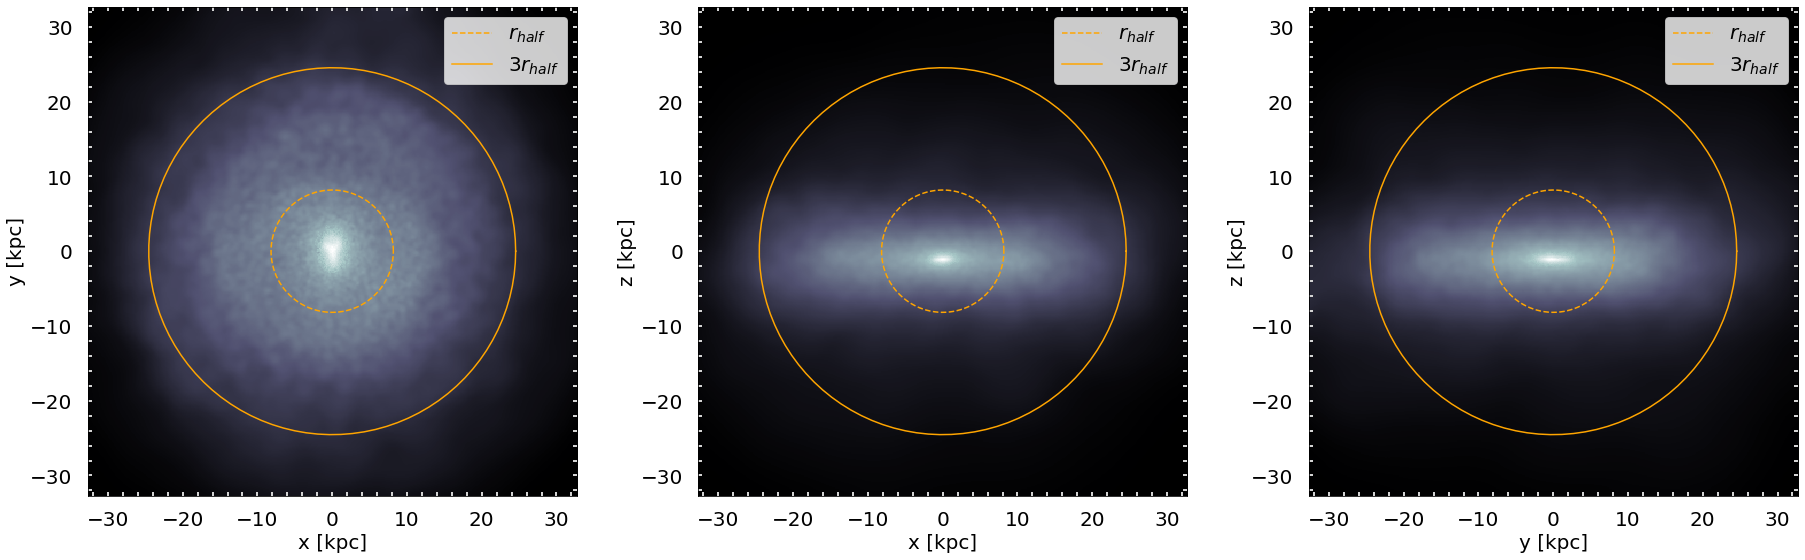

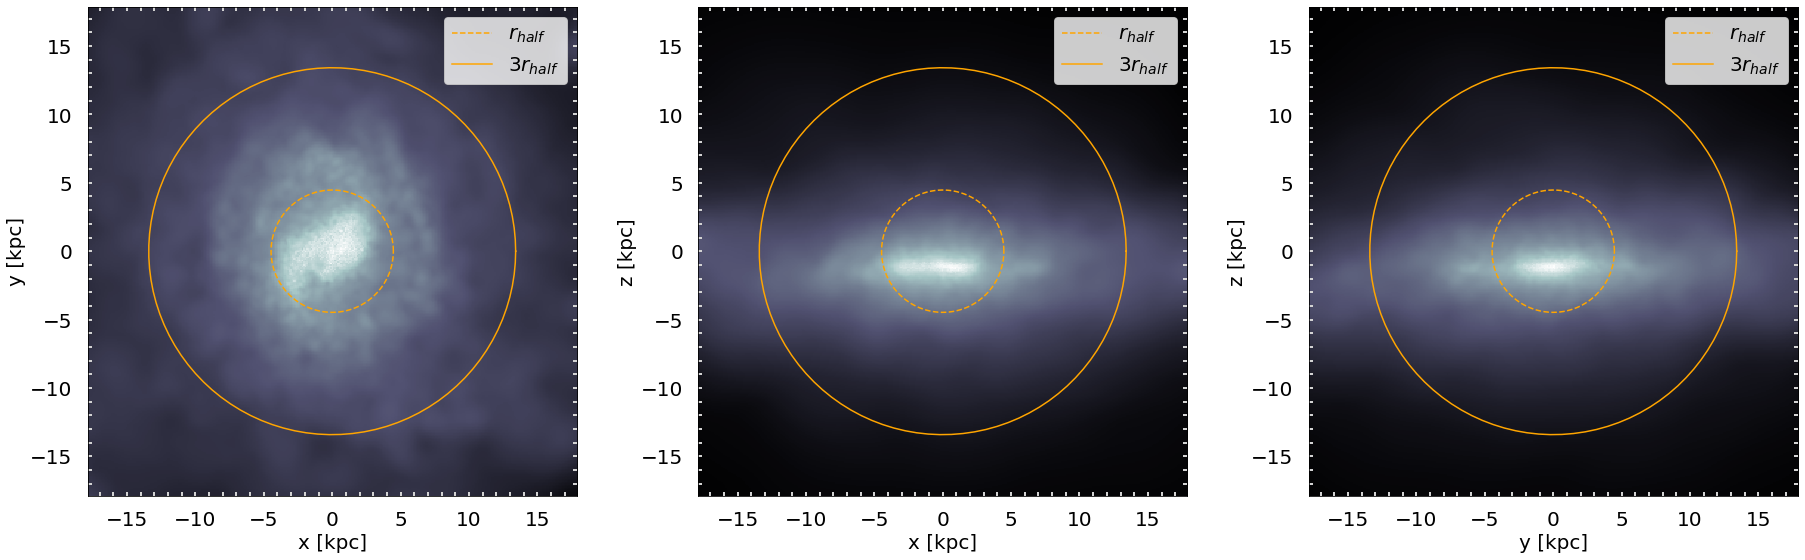

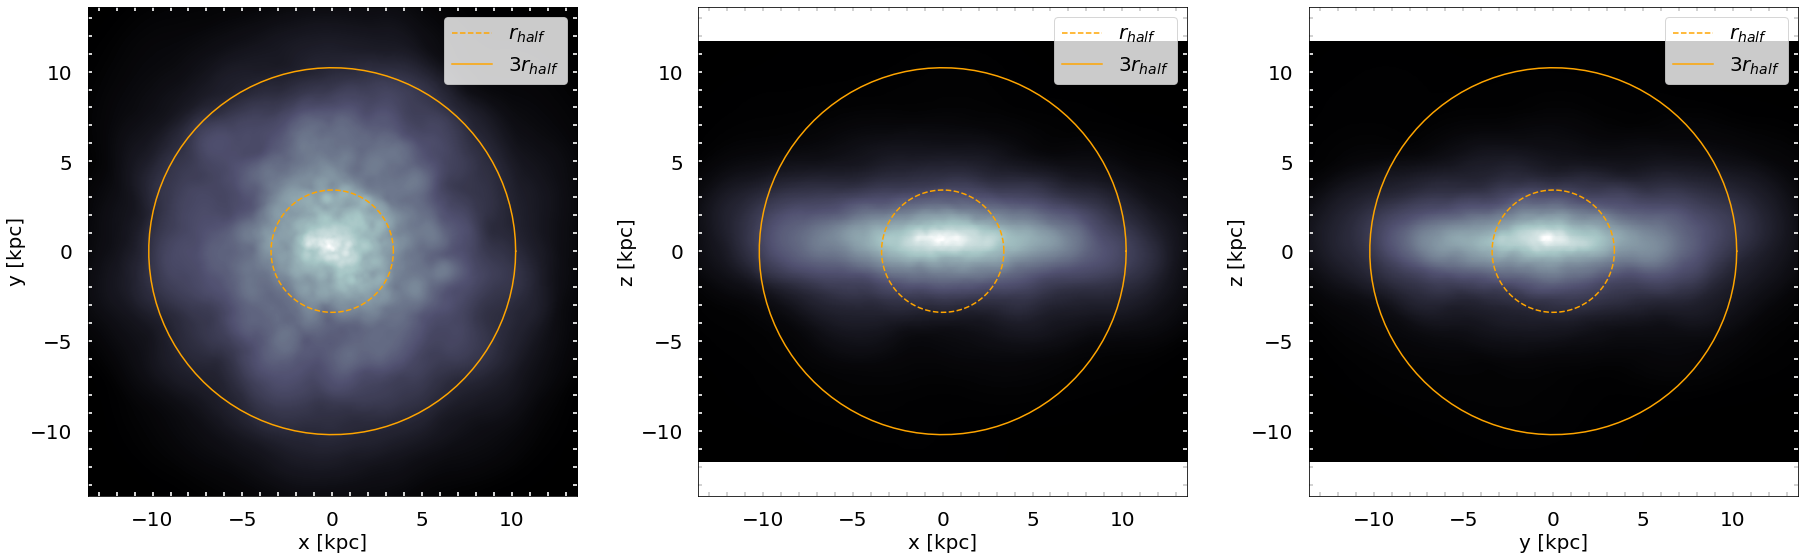

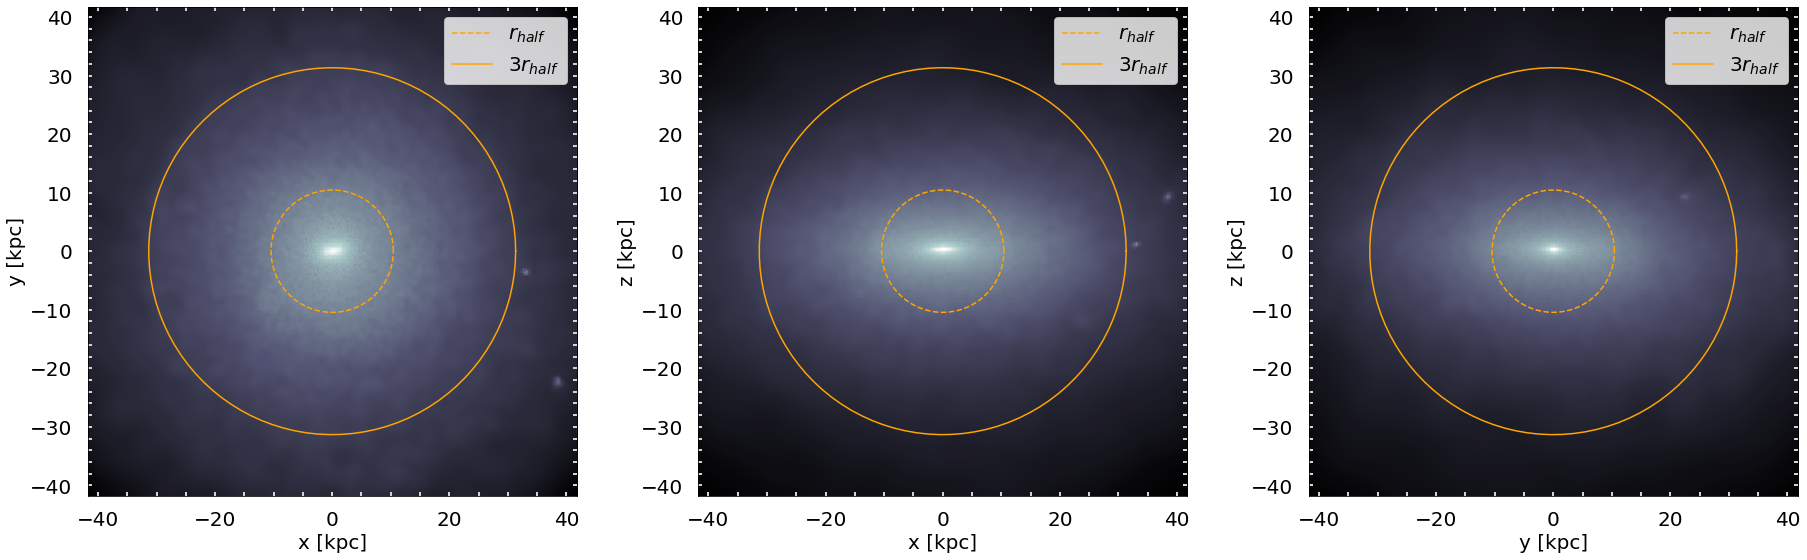

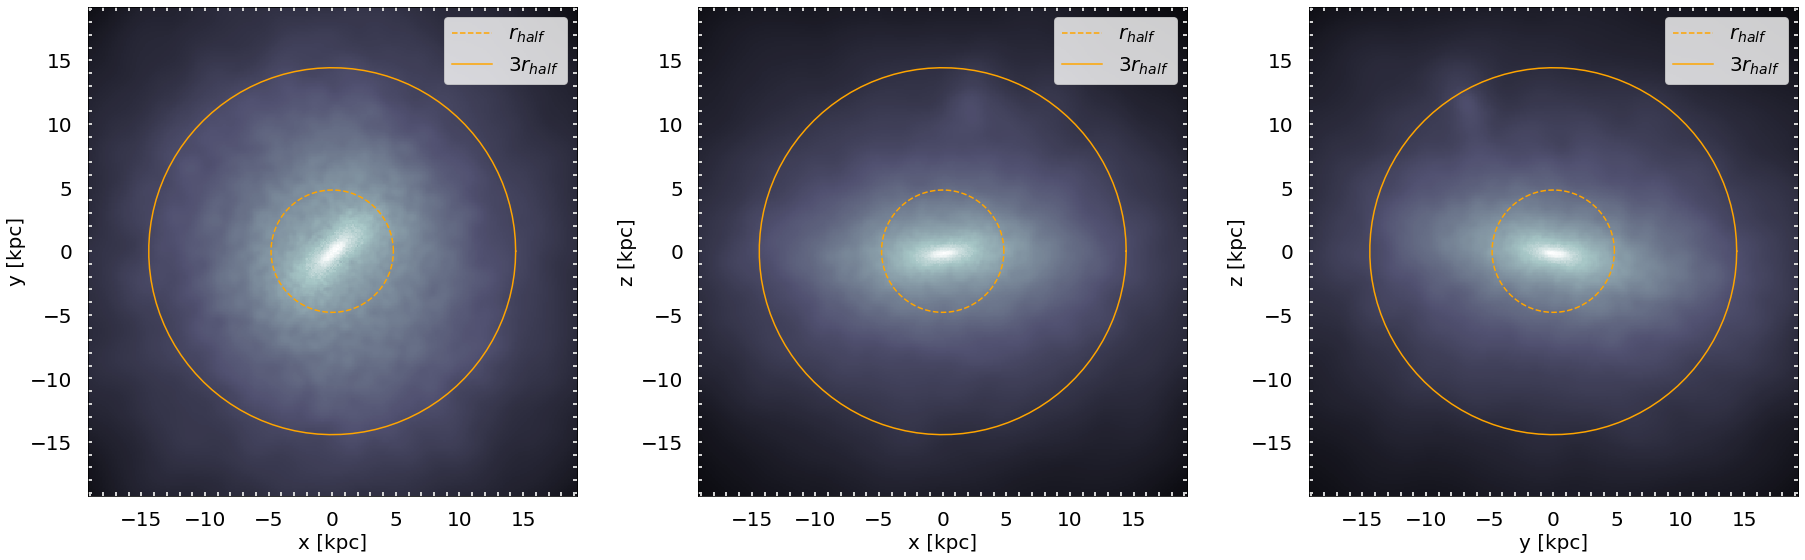

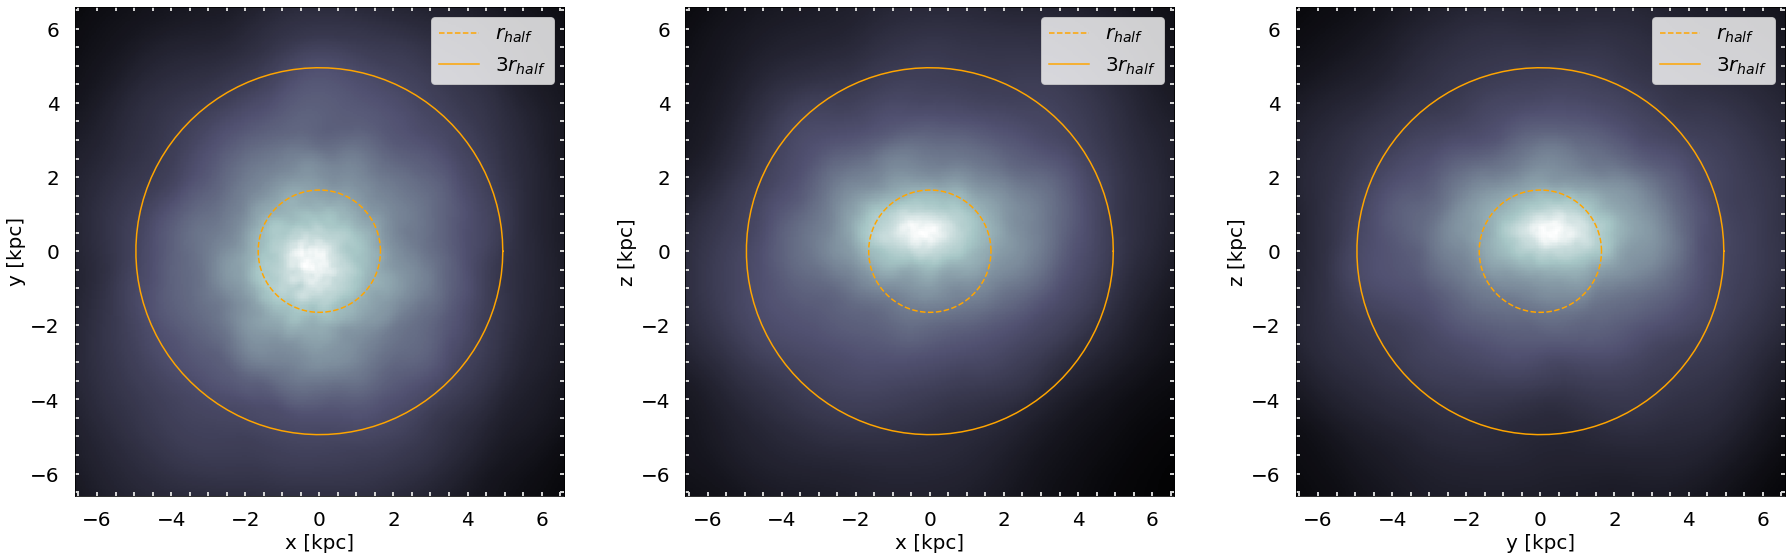

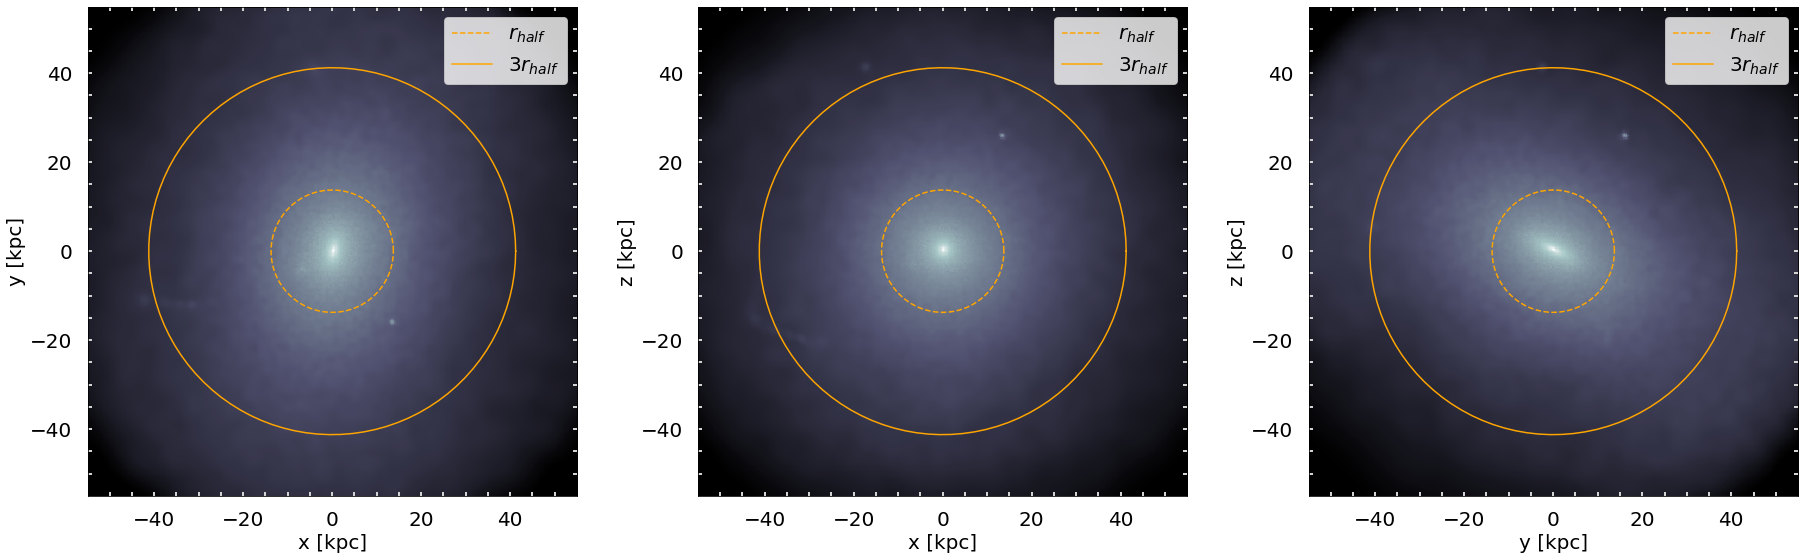

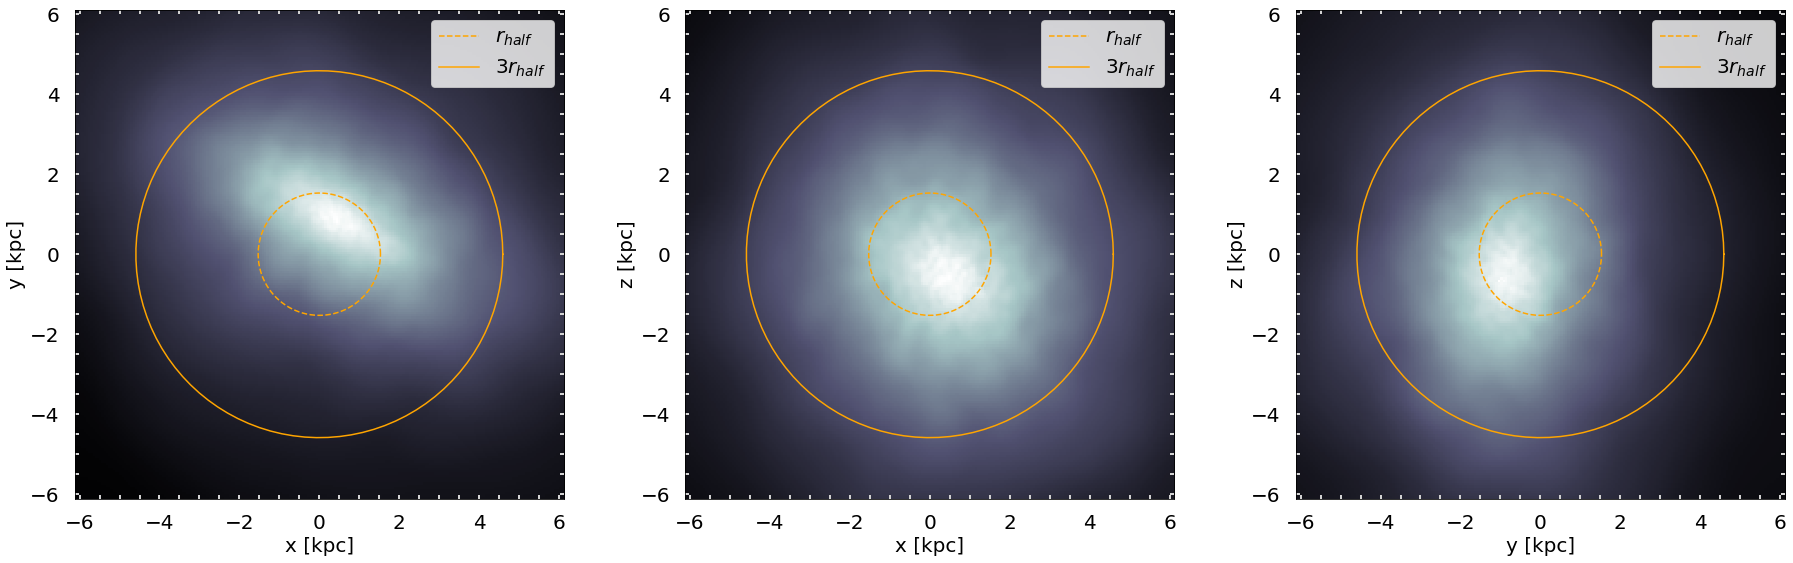

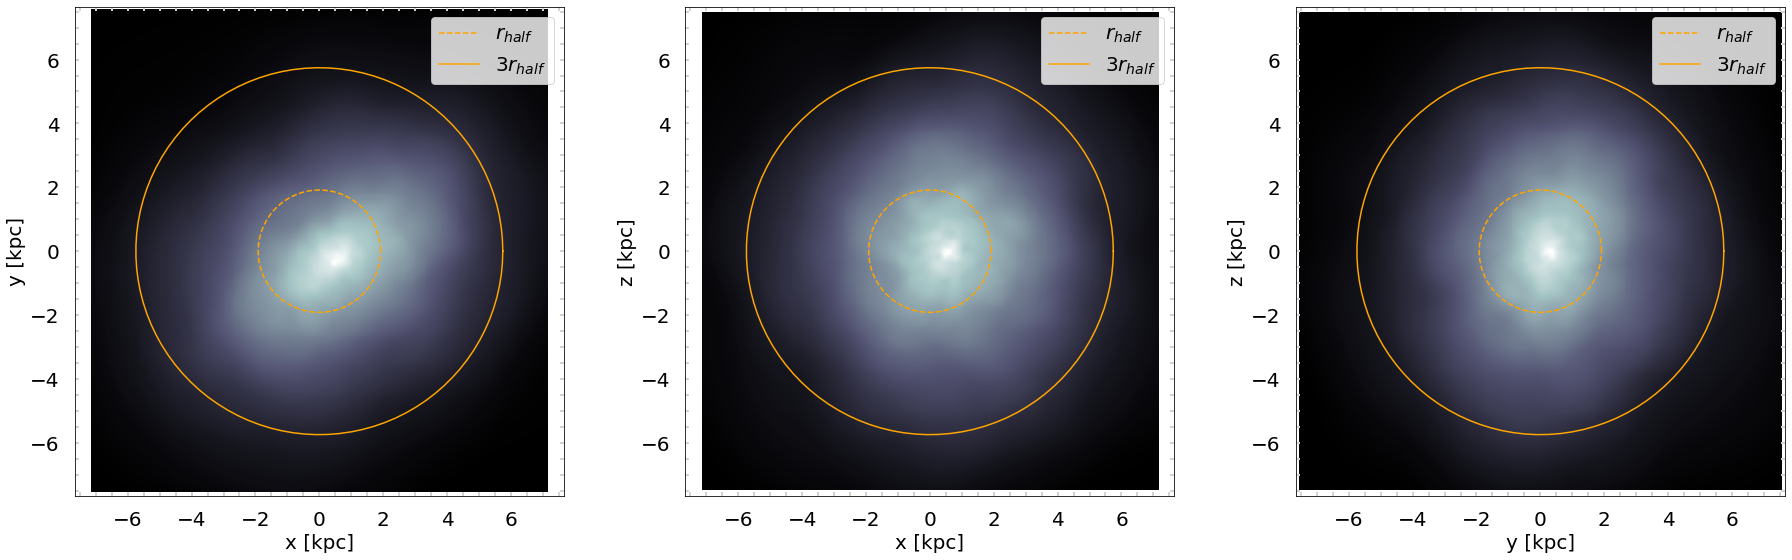

In [5]:
for subhalo_id in subhalos:
    new_cat_path = "../data/" + tng_run + "/catalogues/" + test_name + ".pkl"
    group_cat = pd.read_pickle(new_cat_path)
    subhalo_index = group_cat[group_cat["id"] == subhalo_id].index.values.astype(int)[0]
    rot_vector = np.transpose(np.array([group_cat["AngularMomentumX"][subhalo_index],
        group_cat["AngularMomentumY"][subhalo_index],
        group_cat["AngularMomentumZ"][subhalo_index]]))
    subhalo = stars_out(tng_run, snapshot, subhalo_id)
    subhalo = physics.geometry.rotate_coordinates(subhalo, rot_vector)
    create_projections_SPH(subhalo, group_cat, subhalo_id, test_name)